## Plot tumor purity classification results

Here, we'll visualize the results of our tumor purity prediction. For now, we're trying to predict whether a given sample is above or below the median tumor purity (i.e. classification).

Results analyzed here are generated by the `run_purity_prediction.py` script, with the `--classify` argument.

In [1]:
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import mpmp.config as cfg
import mpmp.utilities.analysis_utilities as au
import mpmp.utilities.data_utilities as du

### Load results

In [2]:
# set results directory
results_dir = Path(cfg.results_dirs['purity'],
                   'purity_binarized_new',
                   'purity').resolve()

In [3]:
results_df = (
    au.load_purity_results(results_dir, classify=True)
      .drop(columns=['identifier'])
)
print(results_df.shape)
print(results_df.training_data.unique())
results_df.head()

(240, 7)
['me_27k' 'me_27k_compressed' 'expression' 'me_450k_compressed'
 'expression_compressed']


,auroc,aupr,training_data,signal,seed,data_type,fold
0,0.50000,0.48196,me_27k,shuffled,1,train,0
1,0.50000,0.47179,me_27k,shuffled,1,test,0
2,0.50023,0.48210,me_27k,shuffled,1,cv,0
3,0.50000,0.47914,me_27k,shuffled,1,train,1
4,0.50000,0.48025,me_27k,shuffled,1,test,1


### Plot results averaged across cancer types

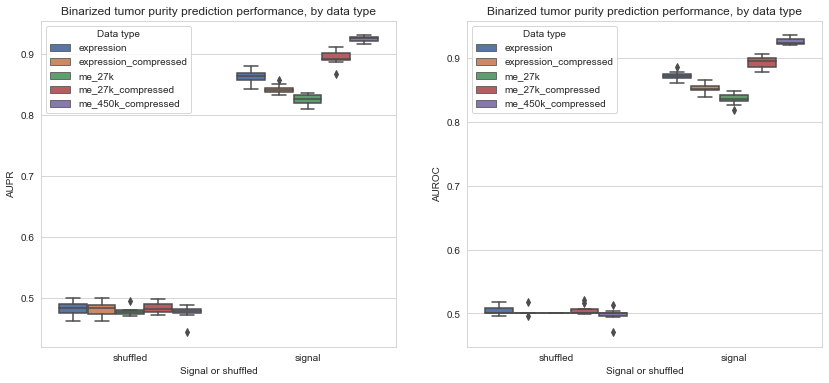

In [4]:
sns.set({'figure.figsize': (14, 6)})
sns.set_style('whitegrid')
fig, axarr = plt.subplots(1, 2)

plot_df = (
    results_df[results_df.data_type == 'test']
      .sort_values(by=['signal', 'training_data'])
)

sns.boxplot(data=plot_df, x='signal', y='aupr', hue='training_data', ax=axarr[0])
axarr[0].set_title('Binarized tumor purity prediction performance, by data type')
axarr[0].set_xlabel('Signal or shuffled')
axarr[0].set_ylabel('AUPR')
axarr[0].legend(title='Data type')
sns.boxplot(data=plot_df, x='signal', y='auroc', hue='training_data', ax=axarr[1])
axarr[1].set_title('Binarized tumor purity prediction performance, by data type')
axarr[1].set_xlabel('Signal or shuffled')
axarr[1].set_ylabel('AUROC')
axarr[1].legend(title='Data type')

### Plot results faceted by cancer type

In [5]:
sample_info_df = du.load_sample_info('expression')
results_df = au.load_purity_by_cancer_type(results_dir, sample_info_df)
print(results_df.training_data.unique())
results_df.head()

['me_27k' 'expression_compressed' 'expression' 'me_450k_compressed'
 'me_27k_compressed']


,training_data,signal,seed,fold_no,cancer_type,aupr,auroc
0,me_27k,shuffled,42,0,LUAD,0.486239,0.5
1,me_27k,shuffled,42,0,GBM,0.538462,0.5
2,me_27k,shuffled,42,0,OV,NaN,NaN
3,me_27k,shuffled,42,0,LUSC,0.505747,0.5
4,me_27k,shuffled,42,0,PRAD,0.491379,0.5


In [6]:
top_cancer_types = (sample_info_df
    .groupby('cancer_type')
    .count()
    .drop(columns=['id_for_stratification'])
    .rename(columns={'sample_type': 'count'})
    .sort_values(by='count', ascending=False)
)
top_cancer_types.head()

,count
cancer_type,
BRCA,1218
KIRC,606
LUAD,576
THCA,572
UCEC,567


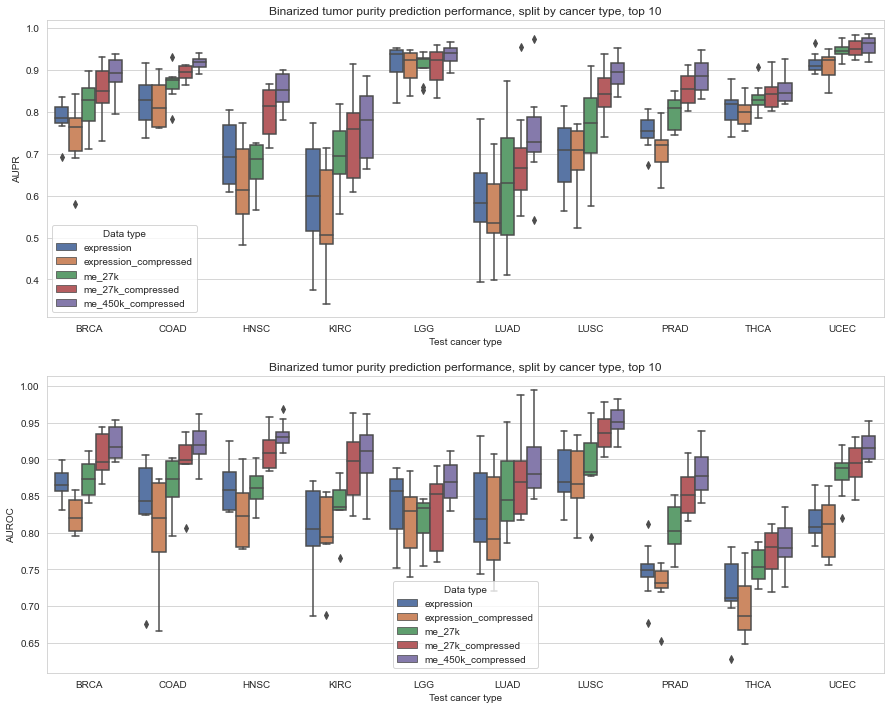

In [7]:
sns.set({'figure.figsize': (15, 12)})
sns.set_style('whitegrid')
fig, axarr = plt.subplots(2, 1)

plot_df = (
    results_df[(results_df.signal == 'signal') &
               (results_df.cancer_type.isin(top_cancer_types.index[:10]))]
      .sort_values(by=['training_data', 'cancer_type'])
)

sns.boxplot(data=plot_df, x='cancer_type', y='aupr', hue='training_data', ax=axarr[0])
axarr[0].set_title('Binarized tumor purity prediction performance, split by cancer type, top 10')
axarr[0].set_xlabel('Test cancer type')
axarr[0].set_ylabel('AUPR')
axarr[0].legend(title='Data type')
sns.boxplot(data=plot_df, x='cancer_type', y='auroc', hue='training_data', ax=axarr[1])
axarr[1].set_title('Binarized tumor purity prediction performance, split by cancer type, top 10')
axarr[1].set_xlabel('Test cancer type')
axarr[1].set_ylabel('AUROC')
axarr[1].legend(title='Data type')

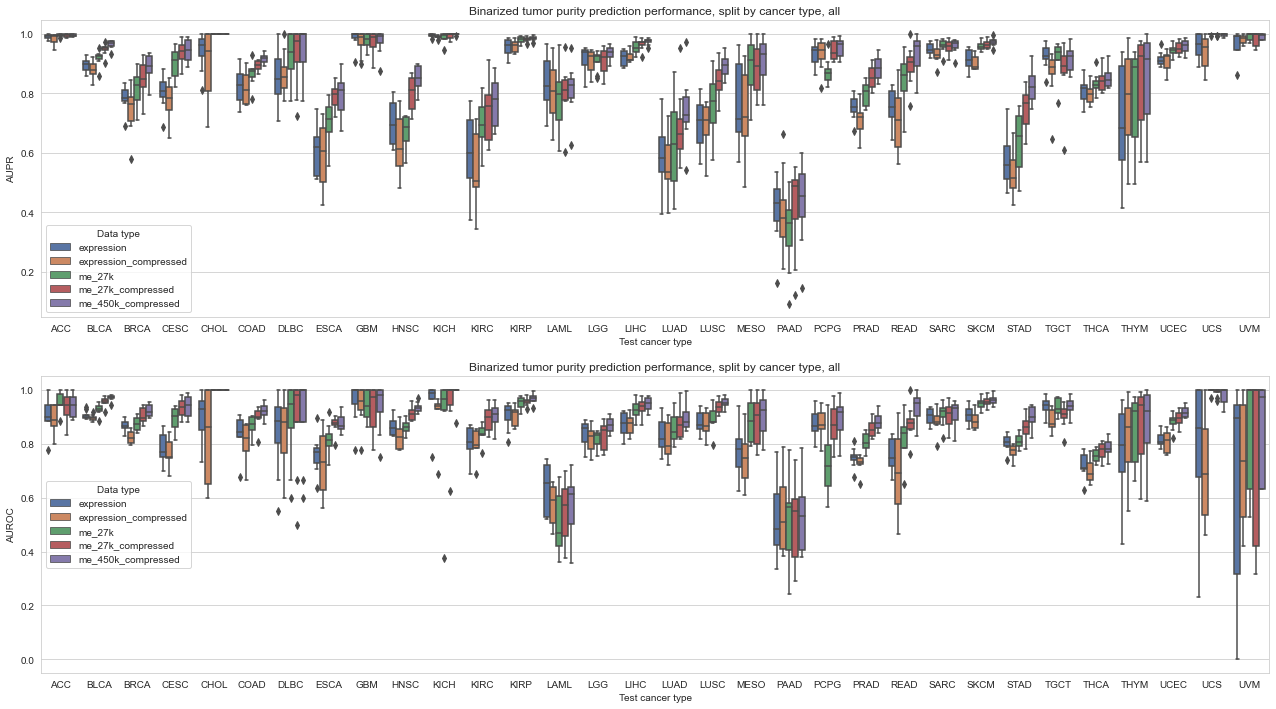

In [8]:
sns.set({'figure.figsize': (22, 12)})
sns.set_style('whitegrid')
fig, axarr = plt.subplots(2, 1)

# ovarian cancer has some NaN metric values due to extreme class imbalance,
# so we just filter it out here
plot_df = (
    results_df[(results_df.signal == 'signal') &
               ~(results_df.cancer_type.isin(['OV']))]
      .sort_values(by=['training_data', 'cancer_type'])
)

sns.boxplot(data=plot_df, x='cancer_type', y='aupr', hue='training_data', ax=axarr[0])
axarr[0].set_title('Binarized tumor purity prediction performance, split by cancer type, all')
axarr[0].set_xlabel('Test cancer type')
axarr[0].set_ylabel('AUPR')
axarr[0].legend(title='Data type')
sns.boxplot(data=plot_df, x='cancer_type', y='auroc', hue='training_data', ax=axarr[1])
axarr[1].set_title('Binarized tumor purity prediction performance, split by cancer type, all')
axarr[1].set_xlabel('Test cancer type')
axarr[1].set_ylabel('AUROC')
axarr[1].legend(title='Data type')